<a href="https://colab.research.google.com/github/rpandya5/gaitanalysis/blob/main/training/training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting google drive to access the dataset
from google.colab import drive

drive.mount('/content/gdrive')

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import random
from sklearn import metrics


os.chdir('/content/gdrive/MyDrive/')

final_data_2  = np.load('CNN-LSTM Data.npy')
labels = np.load('CNN-LSTM Labels.npy')

torch.manual_seed(1) # set the random seed

final_data = torch.from_numpy(final_data_2)

Mounted at /content/gdrive


In [ ]:
class Model(nn.Module):
  def __init__(self, input_size):
    super(Model, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 64 filters, kernel size 3, relu, batch norm, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 128 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 256 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.MaxPool1d(kernel_size=2),
    )

    # LSTM LAYERS

    # 256 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=256, hidden_size=100, batch_first=True)

    # 100 input from lstm1, 100 units, return false
    self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.5),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 256, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 256) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)
    lstm_out, _ = self.lstm_2(lstm_out)

    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
#Helper Functions
def plot_train_val(epoch_list, train_loss, val_loss, title):
    # Plotting

  fig, ax = plt.subplots(figsize=(6, 5))

  plt.title(title+" Curve")

  colors = ["#8D99AE", "#EF233C"]
  # Plot the baseline text
  plt.text(
    epoch_list[-1] * 1.01,
    train_loss[-1],
    "Training " + title,
    color=colors[0],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  plt.text(
    epoch_list[-1] * 1.01,
    val_loss[-1],
    "Validation " + title,
    color=colors[1],
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="center",
  )
  # Hide the all but the bottom spines (axis lines)
  ax.spines["right"].set_visible(False)
  #ax.spines["left"].set_visible(False)
  ax.spines["top"].set_visible(False)

  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position("left")
  ax.xaxis.set_ticks_position("bottom")
  #ax.spines["bottom"].set_bounds(min(x), max(x))


  plt.plot(epoch_list, train_loss, label="Train", color = colors[0], linewidth = 2)
  plt.plot(epoch_list, val_loss, label="Validation", color = colors[1], linewidth = 2)
  plt.xlabel("Epoch")
  plt.ylabel(title)
  plt.legend(loc='best')
  plt.show()

def train(model, data, val_data, batch_size = 64, lr = 0.01, epoch_num = 100):
  #train_queue = tf.train.slice_input_producer([data, train_labels],num_epochs=epoch_num,batch_size = batch_size,shuffle=True)

  train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size)
  #val_queue = tf.train.slice_input_producer([val_data, val_labels], num_epochs=epoch_num,batch_size = batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)

  criterion = nn.BCEWithLogitsLoss()
  optimizer  = torch.optim.Adam(model.parameters(),lr=lr)

  train_err, val_err, train_acc, val_acc = [], [], [], []

  train_t1_err, train_t2_err, val_t1_err, val_t2_err = [], [], [], []

  v_out = []

  epoch_list = range(epoch_num)
  num = 0

  train_loss = []
  val_loss = []
  loss_temp = []

  for epoch in epoch_list:

    error = 0
    count = 0
    t1_err = 0
    t2_err = 0

    for sample, labels in iter(train_loader):
      count += 1
      out = model(sample)         # Compute the output
      loss = criterion(out, labels) # Compute the total loss
      loss.backward()               # Backward pass
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # PyTorch clean up

      # Recalculating the out for the updated model step.
      out = model(sample)
      loss = criterion(out, labels)
      # Save the current training information
      loss_temp.append(float(loss)/batch_size)
      out = torch.sigmoid(out) # Gets the decimal estimations of fall / no fall
      estimate = torch.round(out) # Rounds each estimate to 1 or 0 --> fall or no fall

      type1_error = F.relu(estimate - labels) # Gets all the type 1 errors (predicted fall with no fall)
      type2_error = F.relu(labels - estimate) # Gets all the type 2 errors (predicted no fall with fall)


      diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
      temp = torch.sum(diff) # Sums all the error estimates
      error = temp.item() + error
      t1_err += torch.sum(type1_error).item()
      t2_err += torch.sum(type2_error).item()

    train_acc.append(1 - error/len(data))
    train_err.append(error/len(data))
    train_loss.append(sum(loss_temp)/len(loss_temp))

    train_t1_err.append(t1_err/len(data))
    train_t2_err.append(t2_err/len(data))
    error = 0
    t1_err = 0
    t2_err = 0

    # computing the error and accuracy on a validation set
    loss_temp = []
    count = 0
    error = 0
    v_out = torch.tensor([])
    for sample, labels in iter(val_loader):
      count += 1
      out = model(sample)
      loss = criterion(out, labels)
      out = torch.sigmoid(out) # Gets the decimal estimations of fall / no fall
      estimate = torch.round(out) # Rounds each estimate to 1 or 0 --> fall or no fall
      diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
      temp = torch.sum(diff) # Sums all the error estimates
      error = temp.item() + error

      loss_temp.append(float(loss)/batch_size)
      type1_error = F.relu(estimate - labels) # Gets all the type 1 errors (predicted fall with no fall)
      type2_error = F.relu(labels - estimate) # Gets all the type 2 errors (predicted no fall with fall)
      t1_err += torch.sum(type1_error).item()
      t2_err += torch.sum(type2_error).item()
      v_out = torch.cat((v_out, out))


    val_err.append(error/len(val_data))
    val_acc.append(1 - error/len(val_data))
    val_loss.append(sum(loss_temp)/len(loss_temp))

    val_t1_err.append(t1_err/len(val_data))
    val_t2_err.append(t2_err/len(val_data))

    print("\n\nEpoch ", epoch, "\nTraining Loss         : ",round(train_loss[-1],2), "\nTraining Accuracy     : ", round(train_acc[-1],2), "\nValidation Loss       : ", round(val_loss[-1],2), "\nValidation Accuracy   : ", round(val_acc[-1],2))

  v_out = v_out.view(-1).cpu().detach().numpy()
  plot_train_val(epoch_list, train_loss, val_loss, "Loss")
  plot_train_val(epoch_list, train_acc, val_acc, "Accuracy")
  plot_train_val(epoch_list, train_err, val_err, "Error")

  return v_out

def get_labels(data):
  #Returns the labels
  list = []
  for elem in data:
    list.append(int(elem[-1]))
  return list

def listOfTuples(l1, l2):
  #Merging
  return list(map(lambda x, y:(x,y), l1, l2))

def get_acc(model, data, batch_size):
  correct = 0
  total = 0
  error = 0
  out_list = torch.tensor([])
  for img, labels in torch.utils.data.DataLoader(data, batch_size = batch_size):
    output = model(img)
    output = torch.sigmoid(output) # Gets the decimal estimations of fall / no fall
    estimate = torch.round(output) # Rounds each estimate to 1 or 0 --> fall or no fall
    diff = torch.abs(estimate - labels, out=None) # Gets all the incorrect assessments equal to 1
    temp = torch.sum(diff) # Sums all the error estimates
    error = temp.item() + error

    out_list = torch.cat((out_list, output))

  label_list = get_labels(data)
  out_list = out_list.view(-1).cpu().detach().numpy()
  out_list = [round(i) for i in out_list]
  confusion_matrix_2 = metrics.confusion_matrix(label_list, out_list)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])

  cm_display.plot()
  plt.show()

  return 1 - error / len(data)


In [ ]:
#Getting train, val, test data sets
combined = (listOfTuples((torch.from_numpy(final_data_2)).to(torch.float), torch.from_numpy(labels).to(torch.float)))
random.shuffle(combined)

In [ ]:
train_data = combined[2164:]
val_data = combined[:1082]
test_data = combined[1082:2164]

## Hyperparameter Tuning/Alternate Models

## Version 1:
The model was trained using a batch size of 64 and a learning rate of 0.01 over 100 epochs. It achieved a training accuracy of 100% with a loss of almost 0.0002. It achieved 99.4% accuracy and 0.001 loss on the validation set. Also achieves 99.4% accuracy on test data.

Important Observations:
1. The model reaches almost 99% accuracy with the first epochs only. This suggests that the model is easily able to differentiate between Fall and ADL Activities.
2. Over the last few epochs, we can see from the graphs that the validation/training loss increases by very small amount , indicating that due to the large number of epochs, the model starts to overfit.

In [ ]:
model_1 = Model(56)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.97 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 


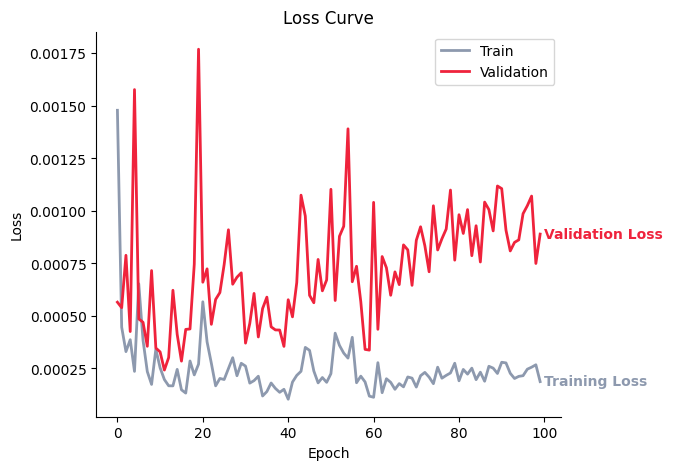

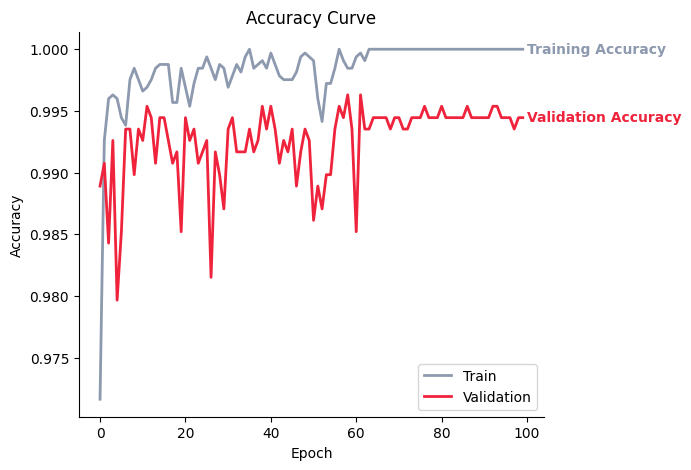

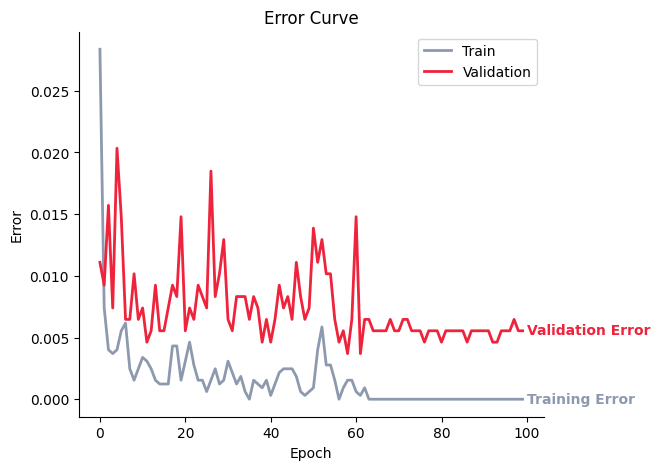

In [ ]:
pred_1 = train(model_1, train_data, val_data)

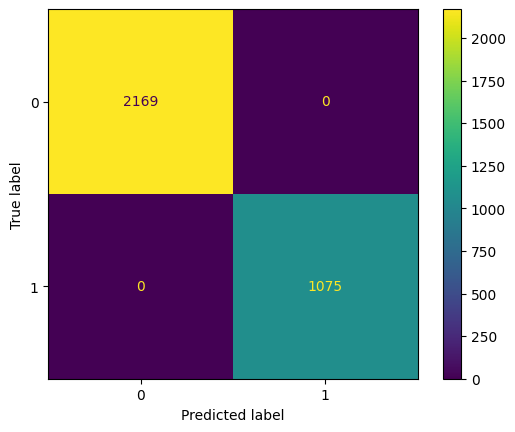

1.0

In [ ]:
get_acc(model_1, train_data, 64)

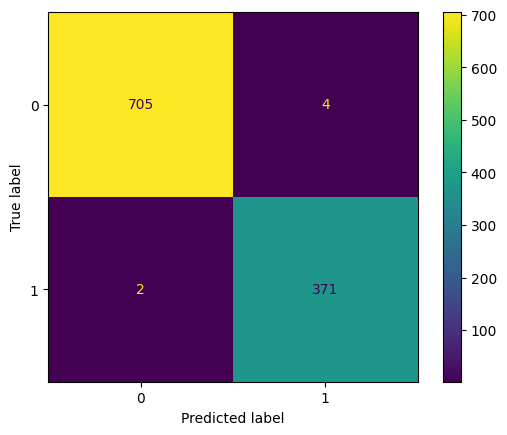

0.9944547134935305

In [ ]:
get_acc(model_1, val_data, 64)

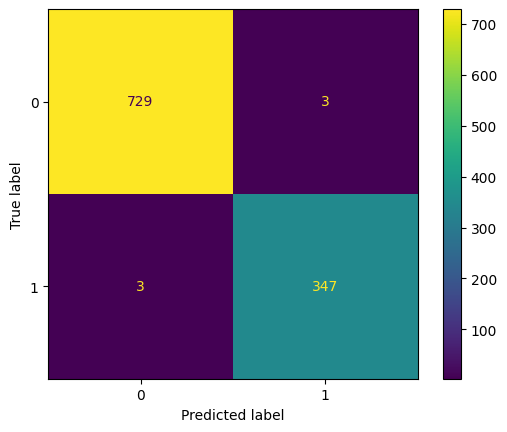

0.9944547134935305

In [ ]:
get_acc(model_1, test_data, 64)

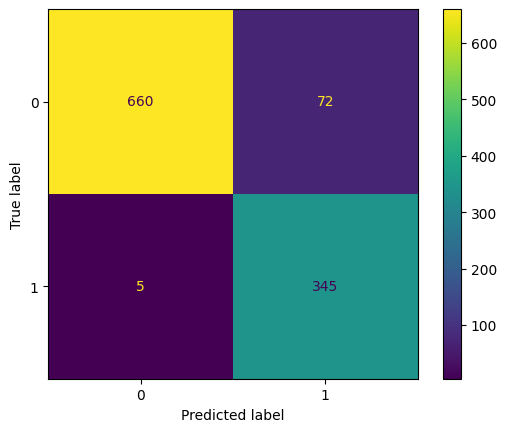

0.9288354898336414

In [ ]:
get_acc(model_1, test_data, 5)

## Version 2

To improve on the previous model's performance, we incorporate the following changes into the hyperparameters:

1. Batch Size has been reduced to 32 to introduce some noise and improve model robustness
2. The number of epochs have been reduced to 30 to prevent overfitting
3. The learning rate has also been reduced to 0.001 to incorporate for the noise due to smaller batch size

Observation: The smaller batch size with the less epochs seemed to have helped as the accuracy and training curves suggest that the model has reached optimal capacity. It achieves 100% accuracy on train with 0 loss and 99.5% validation accuracy and about 0.001 loss. Also achieves 99.3% accuracy on test set.

In [ ]:
model_2 = Model(56)



Epoch  0 
Training Loss         :  0.01 
Training Accuracy     :  0.97 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  0.99 


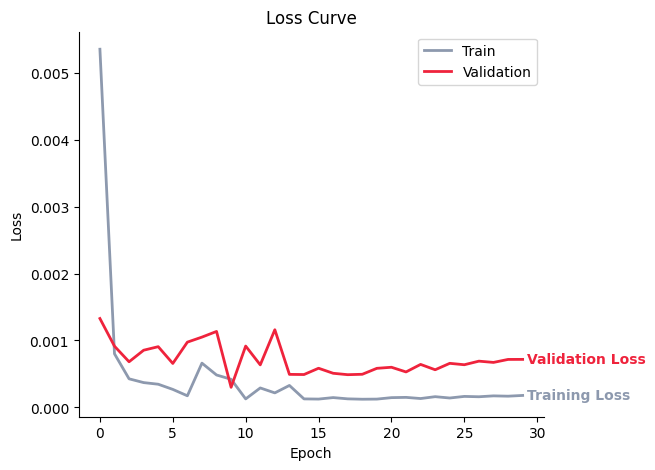

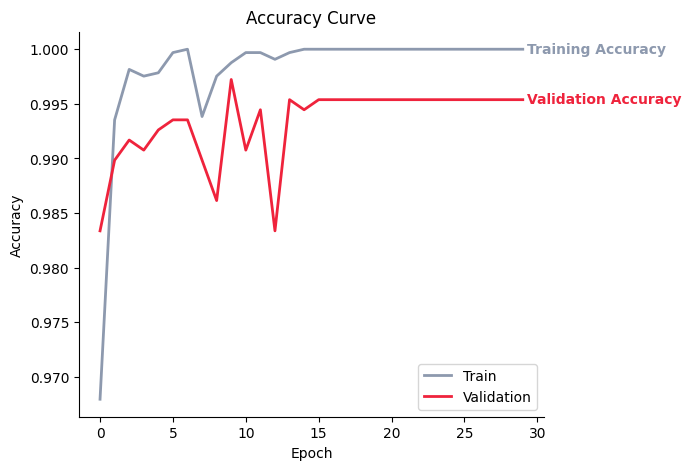

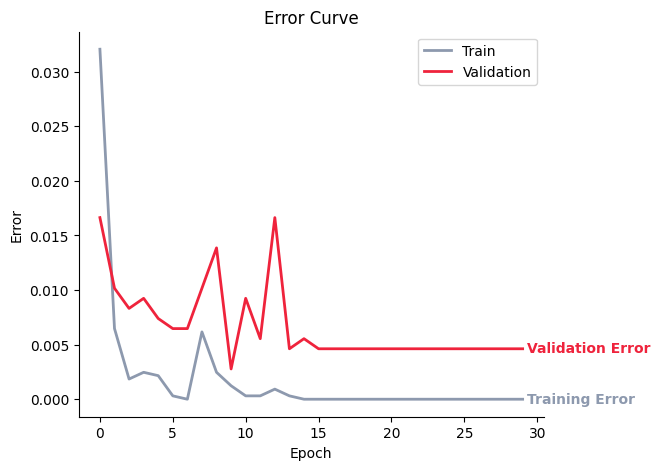

In [ ]:
pred_2 = train(model_2, train_data, val_data, batch_size=32, lr=0.001, epoch_num=30)

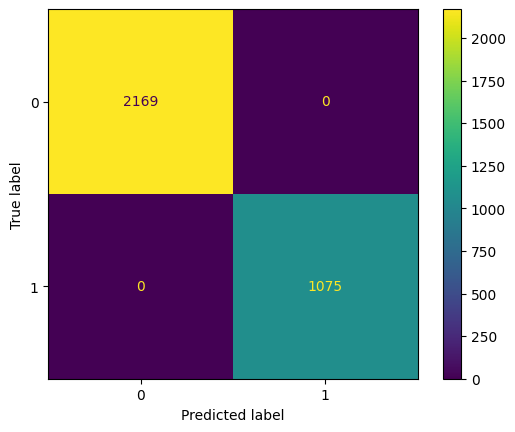

1.0

In [ ]:
get_acc(model_2, train_data, 32)

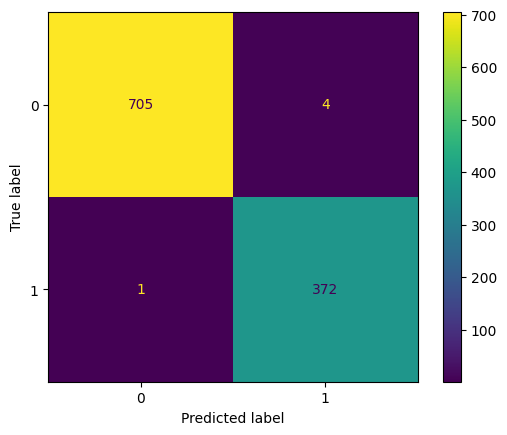

0.9953789279112755

In [ ]:
get_acc(model_2, val_data, 32)

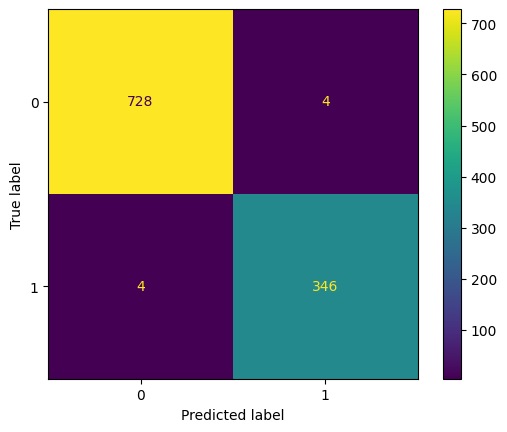

0.9926062846580407

In [ ]:
get_acc(model_2, test_data, 32)

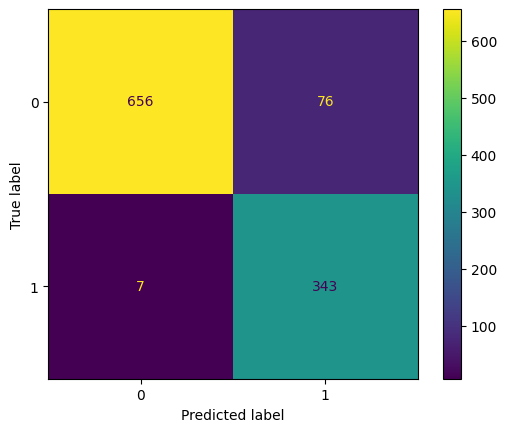

0.9232902033271719

In [ ]:
get_acc(model_2, test_data, 5)

## Version 3

While model 2 performed better on test compared to model 1, we aim to see if increasing the batch size and learning rate can lead to a better and faster convergence:

1. Increase batch size to 128 to reduce computational time
2. Keep the learning rate at 0.01 for the large batch size
3. Reduce the Epochs to 25 to prevent any overfitting

Observation: This improved the model to achieve 100%, 99.7% and 99.4% accuracy on train, validation and test sets. The frequent fluctuations of the loss is a result of the larger learning rate used to train this model compared with versions 1 and 2.

In [ ]:
model_3 = Model(56)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.97 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Valida

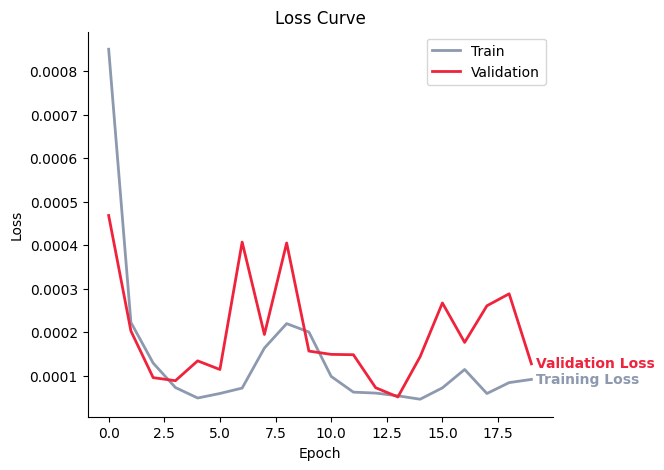

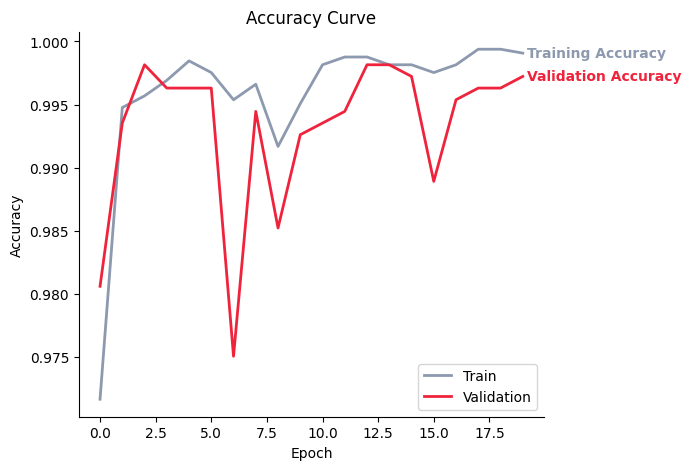

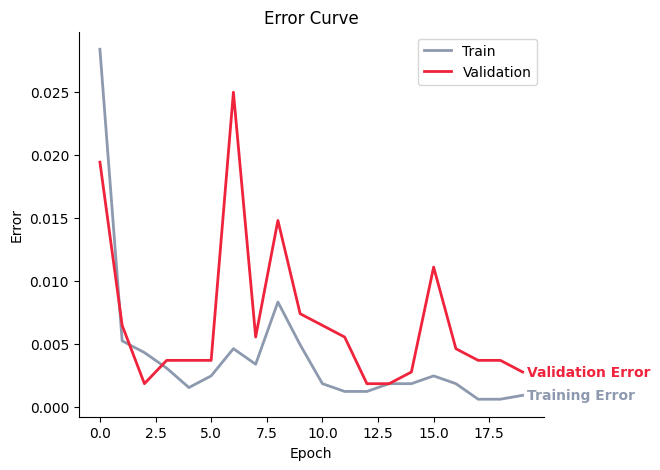

In [ ]:
pred_3 = train(model_3, train_data, val_data, 128, epoch_num=20)

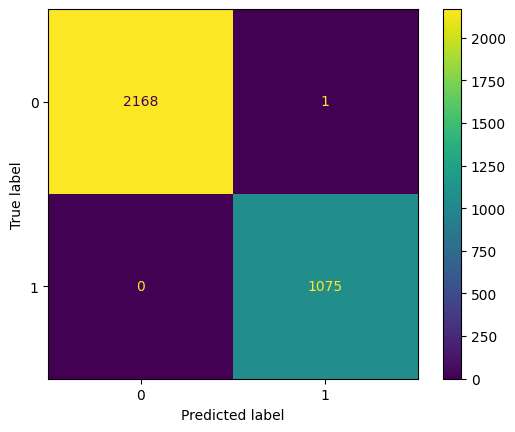

0.999691738594328

In [ ]:
get_acc(model_3, train_data, 128)

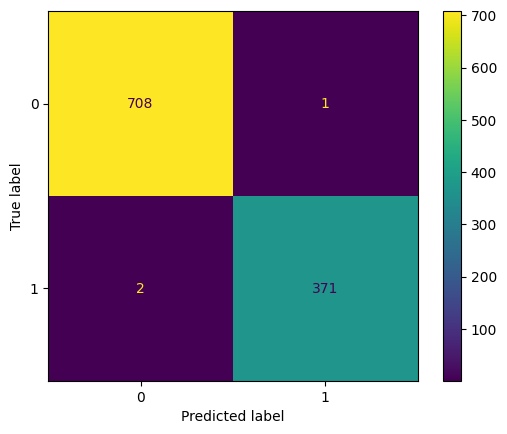

0.9972273567467652

In [ ]:
get_acc(model_3, val_data, 128)

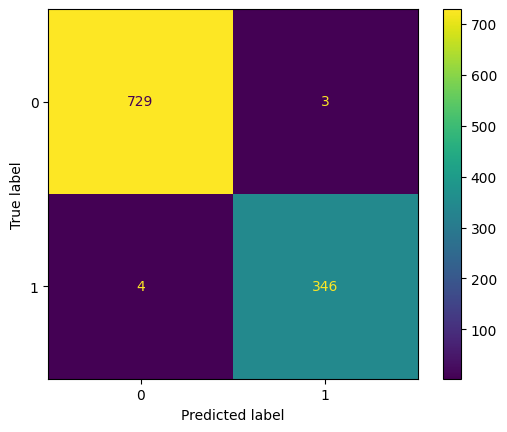

0.9935304990757856

In [ ]:
get_acc(model_3, test_data, 128)

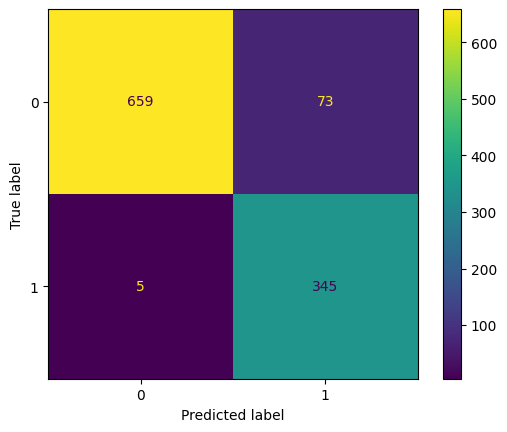

0.9279112754158965

In [ ]:
get_acc(model_3, test_data, 5) #Reduced batch size for testing

## Version 4

This version of the model utilises a simplified version of the previous proposed model. Given that the previous model contained several CNN and LSTM Layers, this model is attempt to explore whether model complexity truly helps to achieve better accuracy on the dataset. It contains only one CNN Layer and one LSTM layer, with the linear layers remaining the same and has been trained on the same batch size of 64, with the same learning rate of 0.01 for about 20 epochs.

Observation: The model achieves 99%, 99.2% and 98.7% accuracy on training, validation and test sets. This tells us that even with a simple model, a high accuracy can be achieved to distinguish between Fall and ADL Activities.

In [ ]:
class SimplifiedModel(nn.Module):
  def __init__(self, input_windows, input_features):
    super(SimplifiedModel, self).__init__()

    # CNN LAYER
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 64 filters, kernel size 14, relu, batch norm (reduce dim)
        nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=input_windows),
        nn.ReLU(),
        nn.BatchNorm1d(64),
    )

    # LSTM LAYERS

    # 64 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=64, hidden_size=100, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.5),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 64, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 64) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)

    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(lstm_out)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
model_4 = SimplifiedModel(14, 56)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.98 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Va

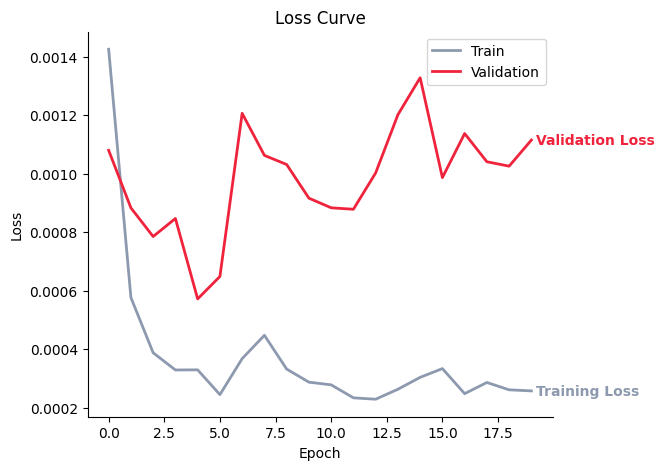

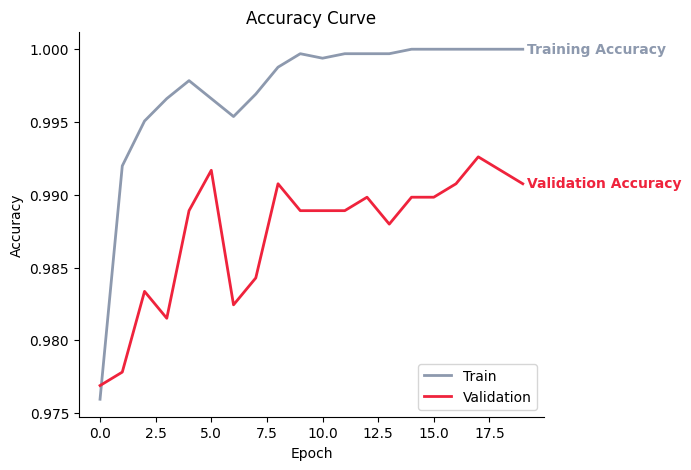

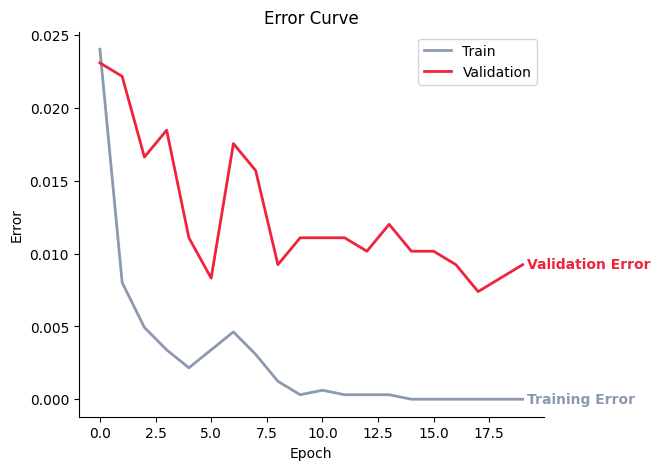

In [ ]:
pred_4 = train(model_4, train_data, val_data, epoch_num = 20)

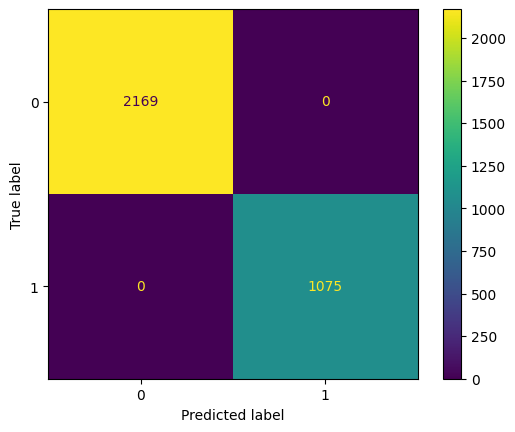

1.0

In [ ]:
get_acc(model_4, train_data, 64)

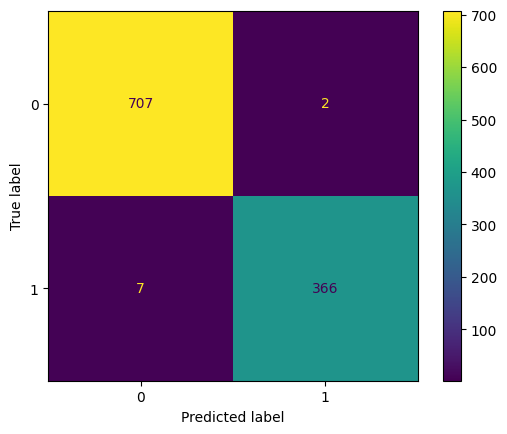

0.9916820702402958

In [ ]:
get_acc(model_4, val_data, 64)

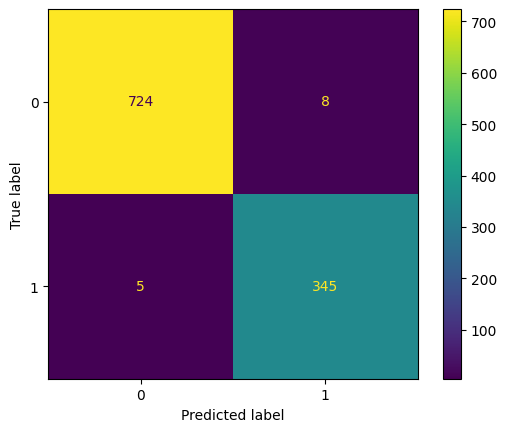

0.987985212569316

In [ ]:
get_acc(model_4, test_data, 64)

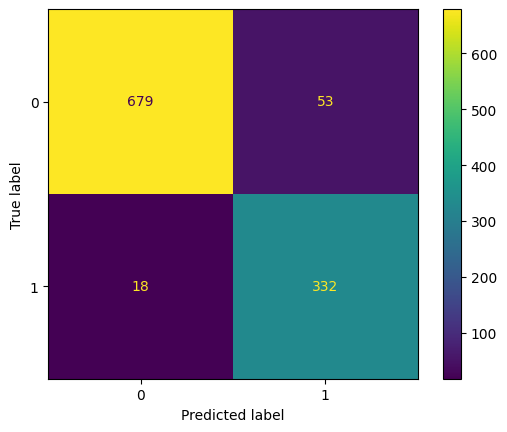

0.9343807763401109

In [ ]:
get_acc(model_4, test_data, 5) #Testing on reduced batch size

## Version 5

Since predicting betweeen Fall and ADL Activities is achieving good results, now we decide to train our model on data with different labels for different activities (while keeping Fall still as one label).

Observation: The paramters were kept at the default parameters (64 batch size and 0.01 learning rate) with 30 epochs. The model achieved 99.2% training, 96.2% validation and 96.4% test accuracy.

**Note: Our project's scope is not to differentiate between different activities but only between Fall and No Fall. This was just for exploration.**

In [ ]:
data_2 = []
labels_2 = []
for dir, _, files in os.walk('/content/gdrive/MyDrive/Processed Data'):
  for file in files:
    file_df = pd.read_csv(os.path.join(dir, file))
    file_df = file_df.drop(['Unnamed: 0', 'Window'], axis=1)
    data_2.append(file_df)
    if file[0] == 'F':
      labels_2.append(0) #Fall
    elif file[:3] == 'D01' or file[:3] == 'D02':
      labels_2.append(1) #Walking
    elif file[:3] == 'D03' or file[:3] == 'D04':
      labels_2.append(2) #Jogging
    elif file[:3] == 'D05' or file[:3] == 'D06':
      labels_2.append(3) #Stair movement
    elif file[:3] == 'D07' or file[:3] == 'D08' or file[:3] == 'D09' or file[:3] == 'D10':
      labels_2.append(4) #Sitting
    elif file[:3] == 'D11' or file[:3] == 'D18':
      labels_2.append(5) #Collapse into chair or stumbling
    elif file[:3] == 'D12' or file[:3] == 'D13':
      labels_2.append(6) #Lying
    elif file[:3] == 'D14':
      labels_2.append(7) #Changing Lying Posture
    elif file[:3] == 'D15' or file[:3] == 'D16':
      labels_2.append(8) #Bending
    elif file[:3] == 'D17':
      labels_2.append(9) #Car in/out
    elif file[:3] == 'D19':
      labels_2.append(10) #Gentle Jump

In [ ]:
data_2_np = np.array(data_2)
labels_2_np = np.array(labels_2)

In [ ]:
data_2_np.shape

In [ ]:
combined = (listOfTuples((torch.from_numpy(data_2_np)).to(torch.float), torch.from_numpy(labels_2_np).to(torch.float)))

In [ ]:
import random
random.shuffle(combined)

In [ ]:
train_data = combined[2164:]
val_data = combined[:1082]
test_data = combined[1082:2164]

In [ ]:
class Model_Multi(nn.Module):
  def __init__(self, input_size):
    super(Model_Multi, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 64 filters, kernel size 3, relu, batch norm, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 128 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 256 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.MaxPool1d(kernel_size=2),
    )

    # LSTM LAYERS

    # 256 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=256, hidden_size=100, batch_first=True)

    # 100 input from lstm1, 100 units, return false
    self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.5),

        # Second Fully Connected Layer, 100 Inputs, 11 Outputs
        nn.Linear(100, 11)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 256, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 256) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)
    lstm_out, _ = self.lstm_2(lstm_out)

    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
def train_multi(model, data, val_data, batch_size = 64, lr = 0.01, epoch_num = 100):
  #train_queue = tf.train.slice_input_producer([data, train_labels],num_epochs=epoch_num,batch_size = batch_size,shuffle=True)

  train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size)
  #val_queue = tf.train.slice_input_producer([val_data, val_labels], num_epochs=epoch_num,batch_size = batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)

  criterion = nn.CrossEntropyLoss()
  optimizer  = torch.optim.Adam(model.parameters(),lr=lr)

  train_err, val_err, train_acc, val_acc = [], [], [], []

  v_out = []

  epoch_list = range(epoch_num)
  num = 0

  train_loss = []
  val_loss = []
  loss_temp = []

  for epoch in epoch_list:

    error = 0
    count = 0

    for sample, labels in iter(train_loader):
      count += 1
      out = model(sample)         # Compute the output
      loss = criterion(out, labels.long()) # Compute the total loss
      loss.backward()               # Backward pass
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # PyTorch clean up

      # Recalculating the out for the updated model step.
      out = model(sample)
      loss = criterion(out, labels.long())
      # Save the current training information
      loss_temp.append(float(loss)/batch_size)
      out = F.softmax(out)

      _, pred = torch.max(out, 1)
      corr = (pred == labels).sum().item()
      err = len(labels) - corr
      error += err

    train_acc.append(1 - error/len(data))
    train_err.append(error/len(data))
    train_loss.append(sum(loss_temp)/len(loss_temp))

    # computing the error and accuracy on a validation set
    loss_temp = []
    error = 0
    count = 0
    v_out = torch.tensor([])
    for sample, labels in iter(val_loader):
      count += 1
      out = model(sample)
      loss = criterion(out, labels.long())
      loss_temp.append(float(loss)/batch_size)
      out = F.softmax(out)

      _, pred = torch.max(out, 1)
      corr = (pred == labels).sum().item()
      err = len(labels) - corr
      error += err
      v_out = torch.cat((v_out, out))

    val_err.append(error/len(val_data))
    val_acc.append(1 - error/len(val_data))
    val_loss.append(sum(loss_temp)/len(loss_temp))

    print("\n\nEpoch ", epoch, "\nTraining Loss         : ",round(train_loss[-1],2), "\nTraining Accuracy     : ", round(train_acc[-1],2), "\nValidation Loss       : ", round(val_loss[-1],2), "\nValidation Accuracy   : ", round(val_acc[-1],2))
  v_out = v_out.view(-1).cpu().detach().numpy()
  plot_train_val(epoch_list, train_loss, val_loss, "Loss")
  plot_train_val(epoch_list, train_acc, val_acc, "Accuracy")
  plot_train_val(epoch_list, train_err, val_err, "Error")

  return v_out

In [ ]:
model_5 = Model_Multi(56)

In [ ]:
train_multi(model_5, train_data, val_data, 64, 0.01, 30)

In [ ]:
def get_acc_multi(model, data, batch_size):
  correct = 0
  total = 0
  error = 0
  out_list = []
  label_list = []
  for img, labels in torch.utils.data.DataLoader(data, batch_size = batch_size):
    output = model(img)
    output = F.sigmoid(output)
    _, predicted = torch.max(output, 1)
    corr = (predicted == labels).sum().item()
    err = len(labels) - corr
    correct += corr
    error += err
    out_list = out_list + [int(x) for x in predicted.detach().tolist()]
    label_list = label_list + [int(x) for x in labels.tolist()]
  confusion_matrix_2 = metrics.confusion_matrix(label_list, out_list)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

  cm_display.plot()
  plt.show()

  return 1 - error / len(data)

In [ ]:
get_acc_multi(model_5, train_data, 64)

In [ ]:
get_acc_multi(model_5, val_data, 64)

In [ ]:
get_acc_multi(model_5, test_data, 64)

##Version 6

An interesting observation on the models was made. The models perform poorly and the accuracy drops signitificantly when the batch sizes are reduced. This is because of the use of BatchNorm in the model layers which can impact model performance.

To know more, read here:

https://www.quora.com/How-does-batch-normalization-behave-differently-at-training-time-and-test-time

Thus, the models trained using batchnorm layers have to have their performance evaluated using the same batch size.

This version, we train on the data set without the use of batch normalization layers in the model to see how the performance can be impacted. Standard Training Parameters- Batch size of 64, learning rate of 0.01 and reduced 30 epochs to prevent any overfitting are used.

Observation: Big Improvement- Removing the Batch Normalization Layers clearly had an impact on training, with the model achieving 99.2% test accuracy irrespective of batch size.


In [ ]:
class NoNormModel(nn.Module):
  def __init__(self, input_size):
    super(NoNormModel, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 64 filters, kernel size 3, relu, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 128 filters, kernel size 3, relu, maxpooling size 2
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 256 filters, kernel size 3, relu, maxpooling size 2
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),
    )

    # LSTM LAYERS

    # 256 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=256, hidden_size=100, batch_first=True)

    # 100 input from lstm1, 100 units, return false
    self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.5),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 256, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 256) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)
    lstm_out, _ = self.lstm_2(lstm_out)

    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
model_6 = NoNormModel(56)



Epoch  0 
Training Loss         :  0.01 
Training Accuracy     :  0.75 
Validation Loss       :  0.0 
Validation Accuracy   :  0.94


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.98 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  0.98 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  0.98 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  0

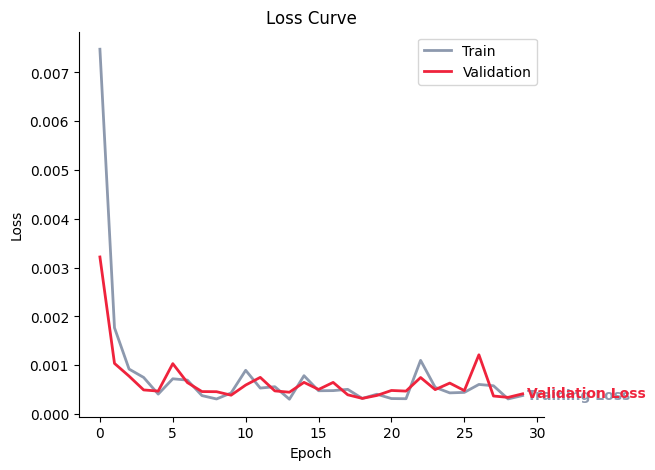

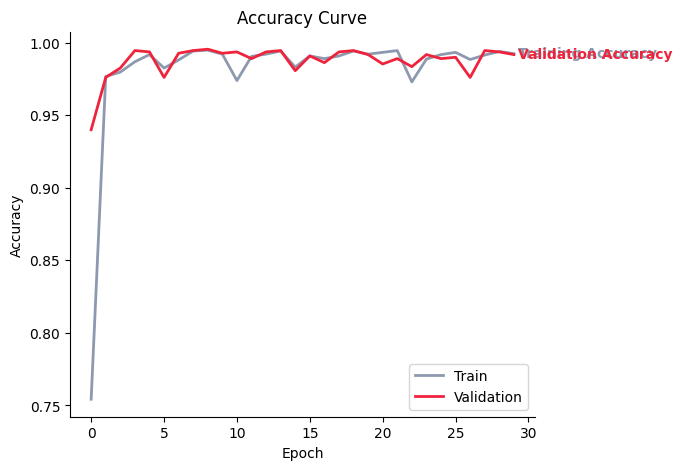

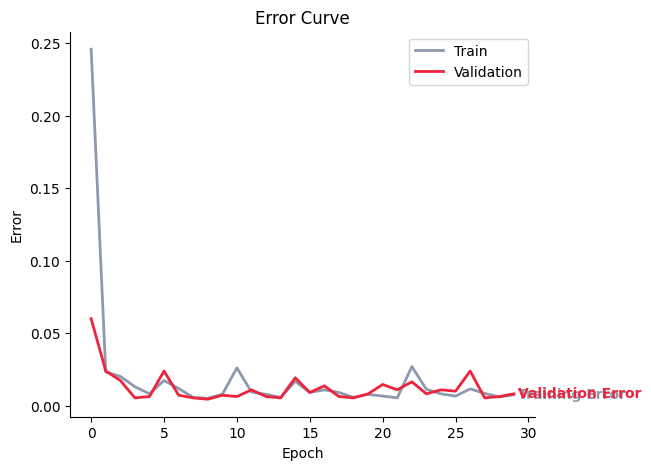

array([5.4680716e-02, 9.9991155e-01, 4.7049392e-03, ..., 4.6105069e-04,
       2.3281577e-04, 3.0948236e-03], dtype=float32)

In [ ]:
train(model_6, train_data, val_data, 64, 0.001, 30)

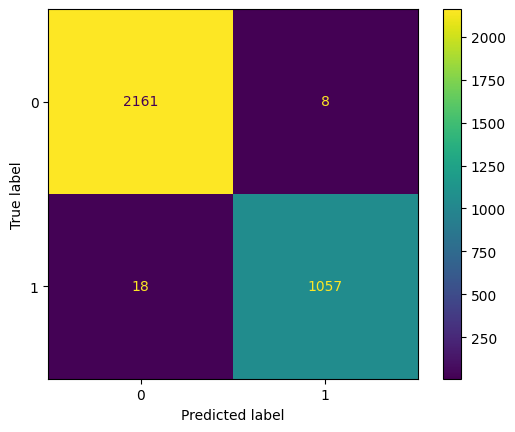

0.9919852034525277

In [ ]:
get_acc(model_6, train_data, 64)

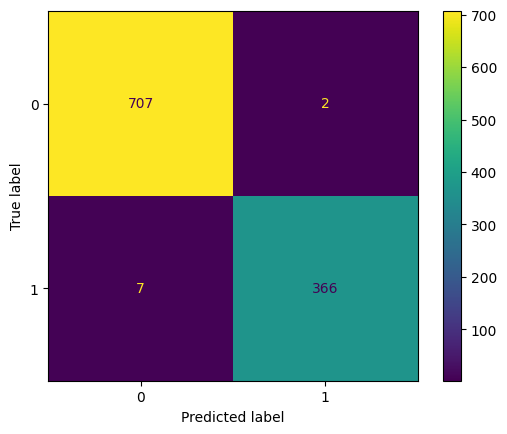

0.9916820702402958

In [ ]:
get_acc(model_6, val_data, 64)

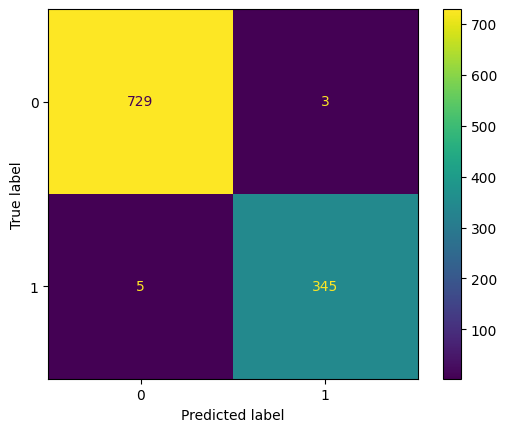

0.9926062846580407

In [ ]:
get_acc(model_6, test_data, 64)

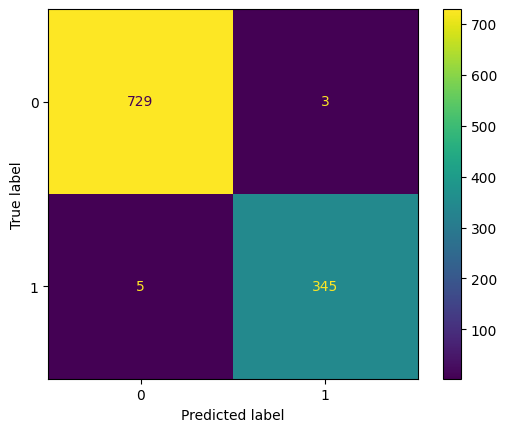

0.9926062846580407

In [ ]:
get_acc(model_6, test_data, 5)

## Version 7

We also want to see how the feature depth affects the model performance. So we reduce the feature depth to 16, 32 and 64 features from 64, 128 and 264 features to see the impact. Model parameters will be a learning rate of 0.001 over a batch size of 64 and 20 epochs.

Observation: The model achieves a training loss of 0 with 100% training accuracy. The model achieves a 99.4% validation accuracy with 0.01 Loss. Test accuracy is at 99.5%.

In [ ]:
class Model2(nn.Module):
  def __init__(self, input_size):
    super(Model2, self).__init__()

    # CNN LAYERS
    self.cnn_layers = nn.Sequential(

        # LAYER 1: 16 filters, kernel size 3, relu, batch norm, maxpooling size 2 (reduce dim)
        nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 2 32 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        nn.MaxPool1d(kernel_size=2),

        # LAYER 3 64 filters, kernel size 3, relu, batch norm, maxpooling size 2
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size=2),
    )

    # LSTM LAYERS

    # 64 input from cnn, 100 units
    self.lstm_1 = nn.LSTM(input_size=64, hidden_size=100, batch_first=True)

    # 100 input from lstm1, 100 units, return false
    self.lstm_2 = nn.LSTM(input_size=100, hidden_size=100, batch_first=True)

    self.fully_connected = nn.Sequential(

        # First Fully Connected Layer 100 Inputs, 100 Outputs
        nn.Linear(100, 100),
        nn.ReLU(),
        # Dropout Layer
        nn.Dropout(0.5),

        # Second Fully Connected Layer, 100 Inputs, 1 Output
        nn.Linear(100, 1)
    )

  def forward(self, x):
    x = x.permute(0, 2, 1) # change shape to (batch_size, input_channels, time_steps)

    cnn_out = self.cnn_layers(x) #shape is now: (batch_size, 64, time_steps // 8)

    lstm_in = cnn_out.permute(0, 2 , 1) #change to batch_size, time_steps // 8, 64) for lstm inpiut

    lstm_out, _ = self.lstm_1(lstm_in)
    lstm_out, _ = self.lstm_2(lstm_out)

    fully_connected_in = lstm_out.view(-1, 100) # reshape to (batch_size, 100)
    fully_connected_out = self.fully_connected(fully_connected_in)
    fully_connected_out = fully_connected_out.view(-1)
    fully_connected_out = fully_connected_out.to(torch.float)

    return fully_connected_out


In [ ]:
model_7 = Model(56)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.95 
Validation Loss       :  0.0 
Validation Accuracy   :  0.97


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Va

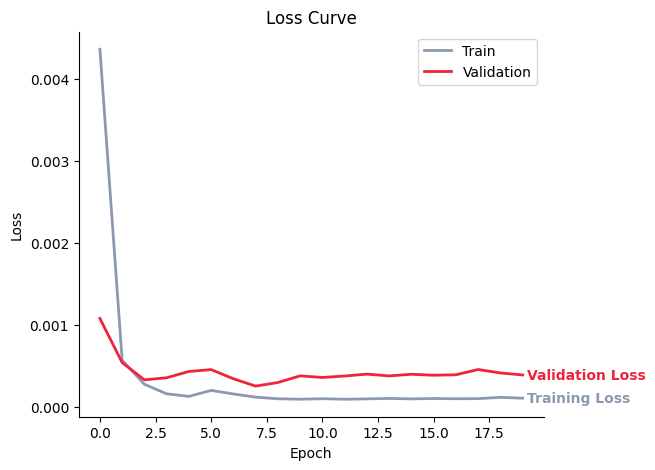

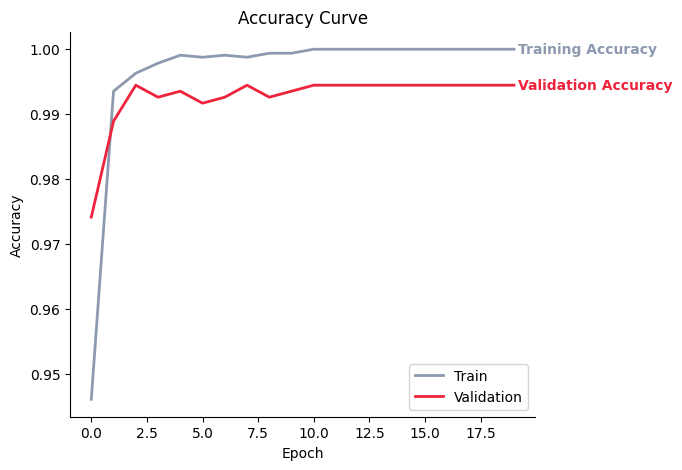

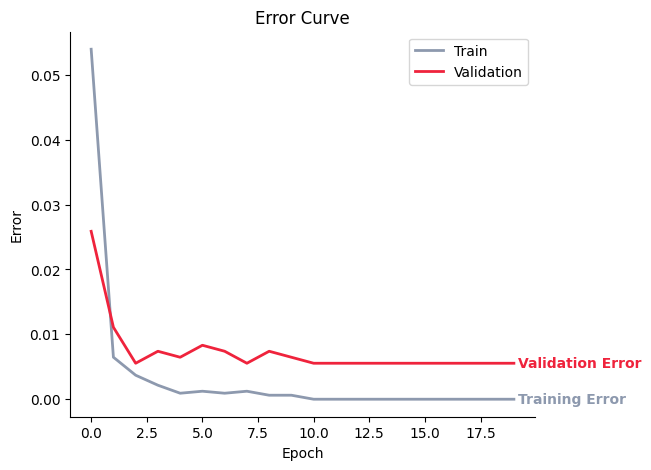

array([5.8349725e-09, 9.9999321e-01, 3.1389611e-06, ..., 4.6314153e-07,
       2.1572612e-06, 1.7904844e-07], dtype=float32)

In [ ]:
train(model_7, train_data, val_data, 64, 0.001, 20)

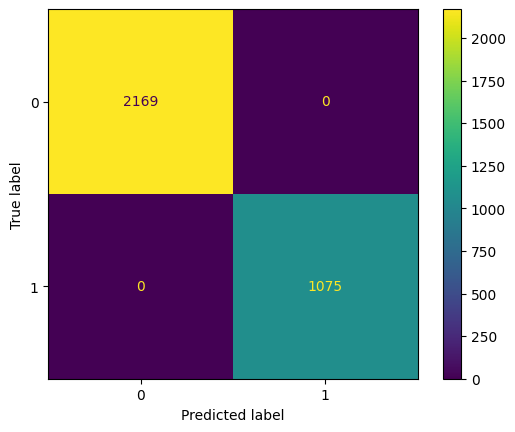

1.0

In [ ]:
get_acc(model_7, train_data, 64)

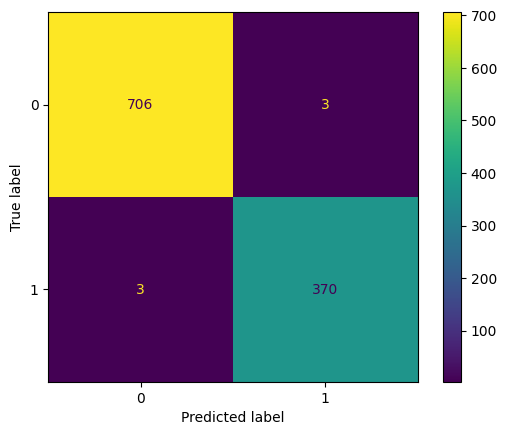

0.9944547134935305

In [ ]:
get_acc(model_7, val_data, 64)

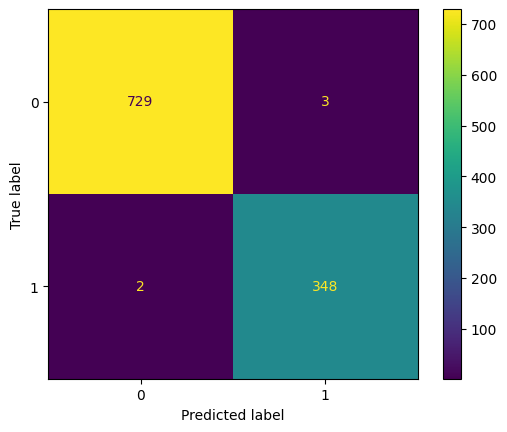

0.9953789279112755

In [ ]:
get_acc(model_7, test_data, 64)

## Version 8

We also experiment with scaling our data. Since we know that the range of values for SisFall is larger compared to readings for Phone Collected Data, I decided to using MinMax Scaler to scale the values. The reason we opted for this scaler is because phone sensor data can be both positive and negative and thus to scale them uniformly as depending on the phone's orientation, the signs can change, the minmax scaler helps us to accomplish uniformity amongst the sensor data. This would ensure more consistency between both train and test data sets. We also use the Model version with no batch normalization as the input data has already been normalized.

Training Parameters are the same with a batch size of 64, learning rate of 0.01 and 30 epochs for preventing overfitting.

Observation: Model seems to achieve high accuracy results as it achieves almost 100% accuracy across all 3 sets of data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.row_stack(final_data_2))

MinMaxScaler()

In [ ]:
final_data_2_scaled = np.array([scaler.transform(final_data_2[i]) for i in range(len(final_data_2))])

In [ ]:
final_data_2_scaled.shape

(5408, 14, 56)

In [ ]:
#Getting train, val, test data sets
combined = (listOfTuples((torch.from_numpy(final_data_2_scaled)).to(torch.float), torch.from_numpy(labels).to(torch.float)))
random.shuffle(combined)

In [ ]:
train_data = combined[2164:]
val_data = combined[:1082]
test_data = combined[1082:2164]

In [ ]:
model_8 = NoNormModel(56)



Epoch  0 
Training Loss         :  0.01 
Training Accuracy     :  0.66 
Validation Loss       :  0.01 
Validation Accuracy   :  0.67


Epoch  1 
Training Loss         :  0.01 
Training Accuracy     :  0.76 
Validation Loss       :  0.0 
Validation Accuracy   :  0.95


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  0.96 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     : 

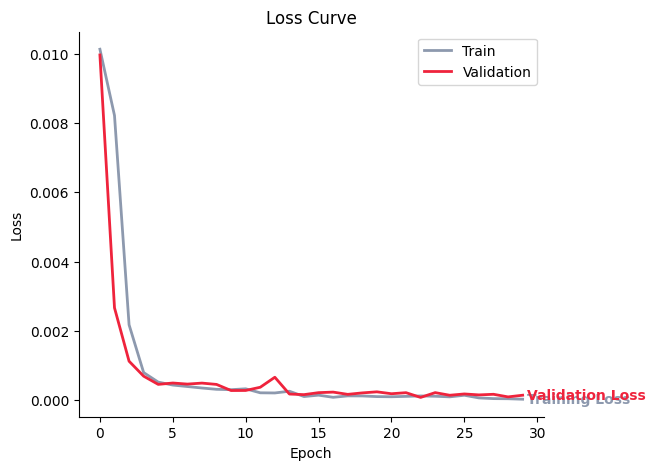

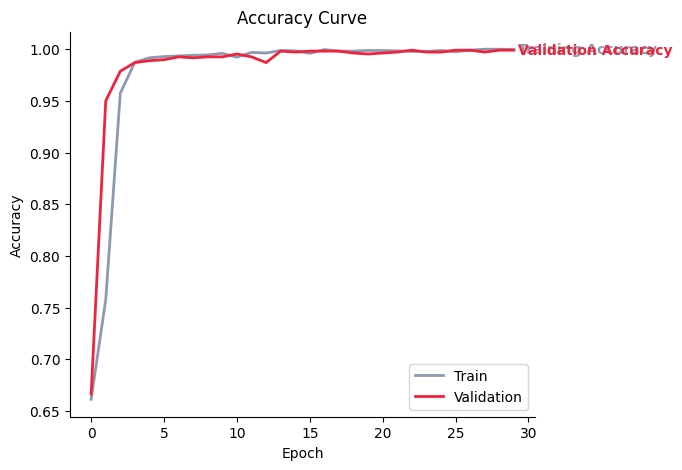

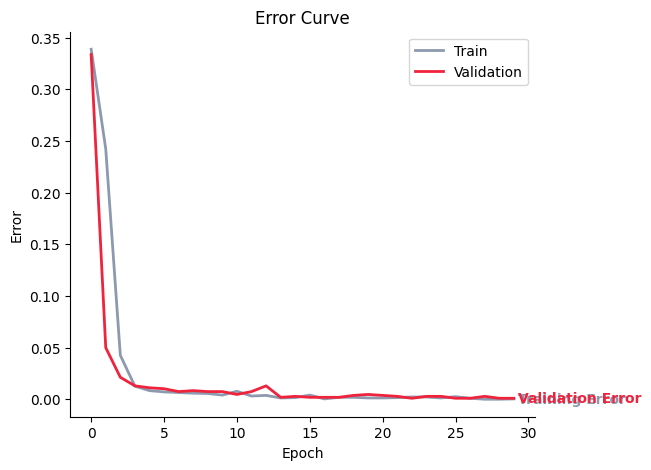

array([8.6660748e-06, 1.3363936e-06, 1.1713550e-05, ..., 9.9998033e-01,
       2.3893710e-05, 1.6031528e-04], dtype=float32)

In [ ]:
train(model_8, train_data, val_data, 64, 0.001, 30)

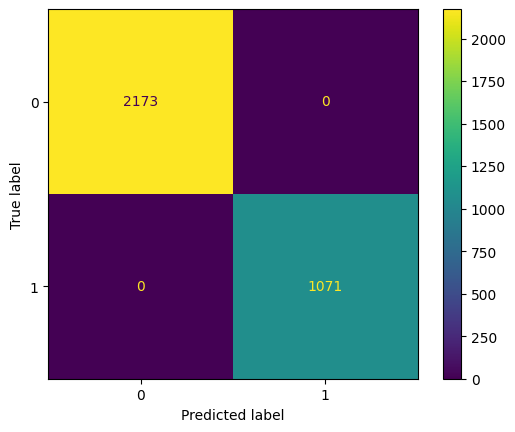

1.0

In [ ]:
get_acc(model_8, train_data, 64)

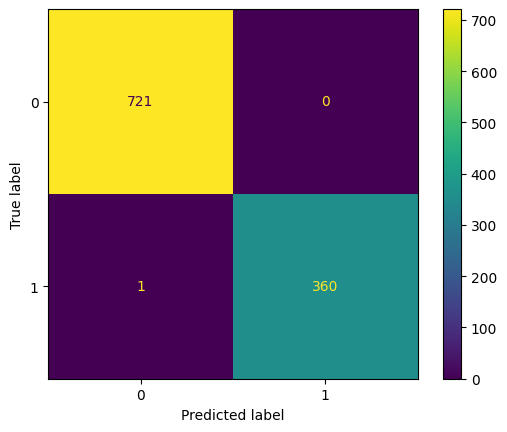

0.9990757855822551

In [ ]:
get_acc(model_8, val_data, 64)

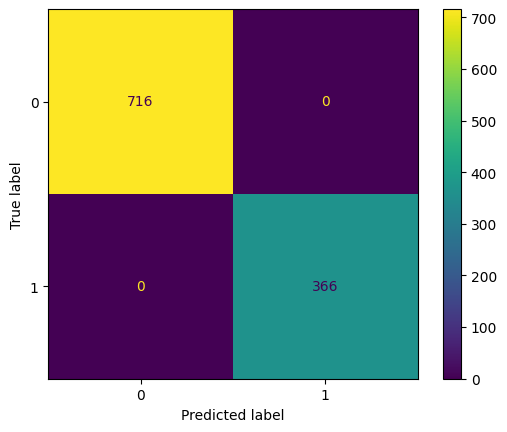

1.0

In [ ]:
get_acc(model_8, test_data, 64)

## Version 9

We now pass in only accelerometer data to see if it has any impact on the model performance. We continue to use the NoNormModel as the model is not unstable. Batch size and learning rate remain same but we have reduced epochs to 20 to prevent any overfitting (model learns very quickly as seen in other models).

Observation: Almost 100% accuracy achieved across all 3 data sets.

In [ ]:
final_data_acc = np.array([final_data_2[i][:,:28] for i in range(len(final_data_2))])

In [ ]:
#Getting train, val, test data sets
combined = (listOfTuples((torch.from_numpy(final_data_acc)).to(torch.float), torch.from_numpy(labels).to(torch.float)))
random.shuffle(combined)

In [ ]:
train_data = combined[2164:]
val_data = combined[:1082]
test_data = combined[1082:2164]

In [ ]:
model_9 = NoNormModel(28)



Epoch  0 
Training Loss         :  0.0 
Training Accuracy     :  0.96 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  0.98


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validati

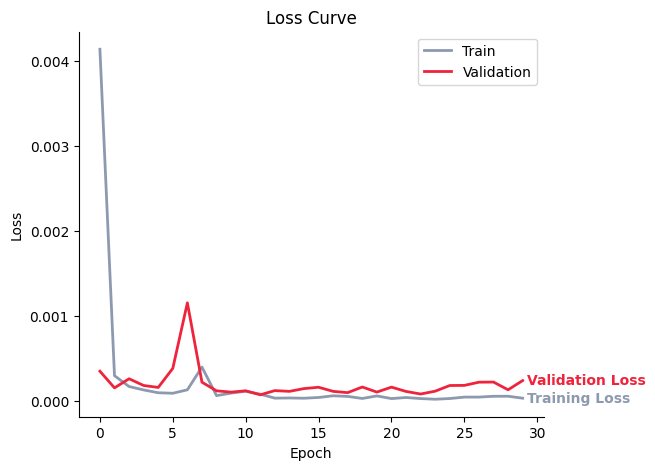

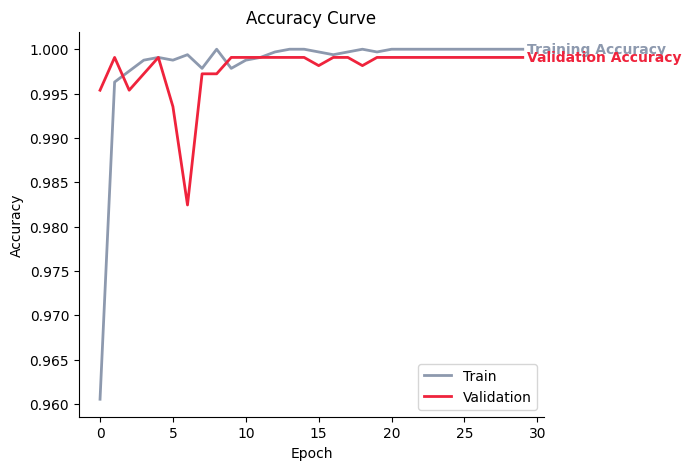

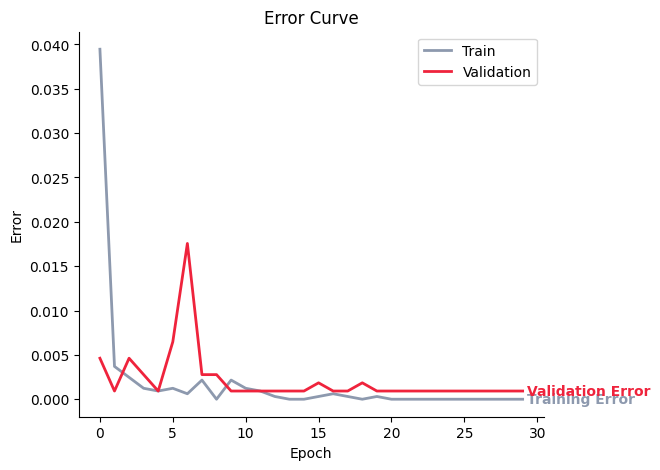

array([1.6380345e-09, 1.4543619e-06, 4.4735675e-06, ..., 1.9844704e-06,
       9.9998415e-01, 1.5396810e-04], dtype=float32)

In [ ]:
train(model_9, train_data, val_data, 64, 0.001, 30)

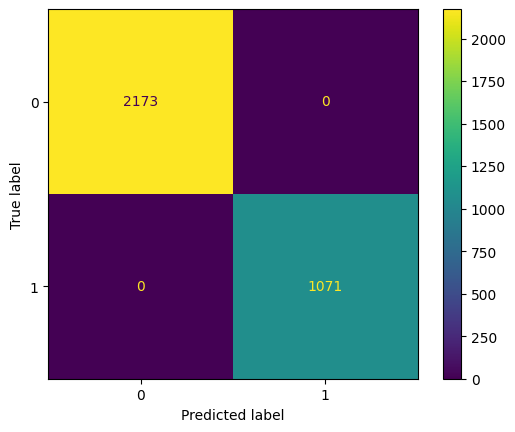

1.0

In [ ]:
get_acc(model_9, train_data, 64)

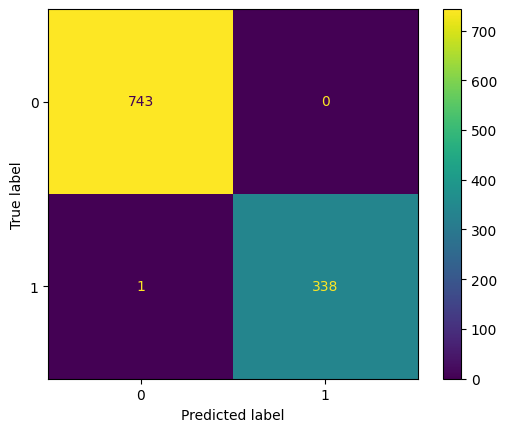

0.9990757855822551

In [ ]:
get_acc(model_9, val_data, 64)

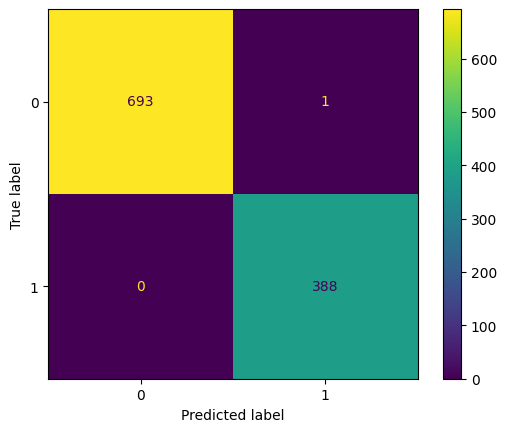

0.9990757855822551

In [ ]:
get_acc(model_9, test_data, 64)

## Version 10

Version 8's scaling is such that it utilizes the maximum readings of the entire training set. The issue with this can be that due to larger acceleration readings in certain activities, scaled data loses subtle changes for individual activities. To remove this, we decided to scale the samples individually which helps to retain the subtle changes in the data.

The Model without Normalization has been used as the data has already been normalized. Learning Rate and Batch sizes are same and the epochs are also kept at 30.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
final_data_scaled = []
for i in range(len(final_data_2)):
  sample = final_data_2[i]
  final_data_scaled.append(scaler.fit_transform(sample))
final_data_scaled = np.array(final_data_scaled)

In [ ]:
combined = (listOfTuples((torch.from_numpy(final_data_scaled)).to(torch.float), torch.from_numpy(labels).to(torch.float)))
random.shuffle(combined)

In [ ]:
train_data = combined[2164:]
val_data = combined[:1082]
test_data = combined[1082:2164]

In [ ]:
model_10 = NoNormModel(56)



Epoch  0 
Training Loss         :  0.01 
Training Accuracy     :  0.71 
Validation Loss       :  0.0 
Validation Accuracy   :  0.91


Epoch  1 
Training Loss         :  0.0 
Training Accuracy     :  0.97 
Validation Loss       :  0.0 
Validation Accuracy   :  0.99


Epoch  2 
Training Loss         :  0.0 
Training Accuracy     :  0.99 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  3 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  4 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  5 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  6 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Validation Loss       :  0.0 
Validation Accuracy   :  1.0


Epoch  7 
Training Loss         :  0.0 
Training Accuracy     :  1.0 
Valid

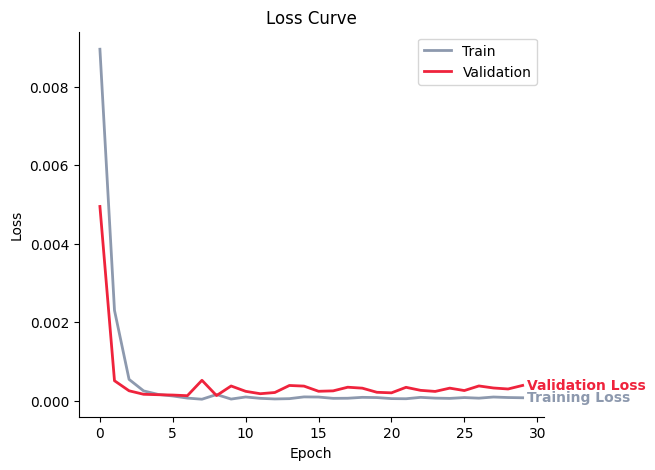

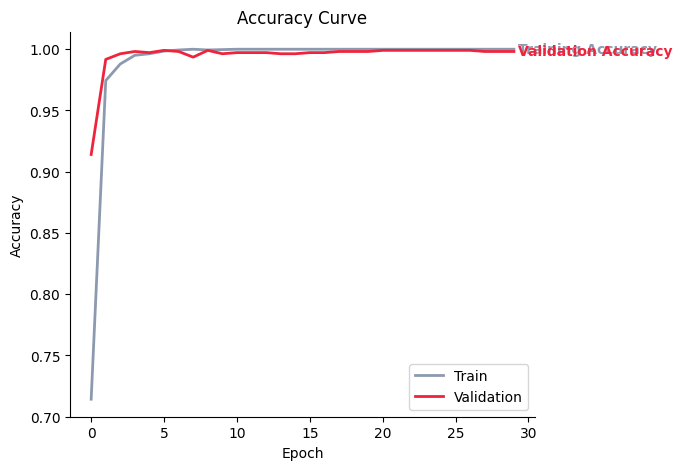

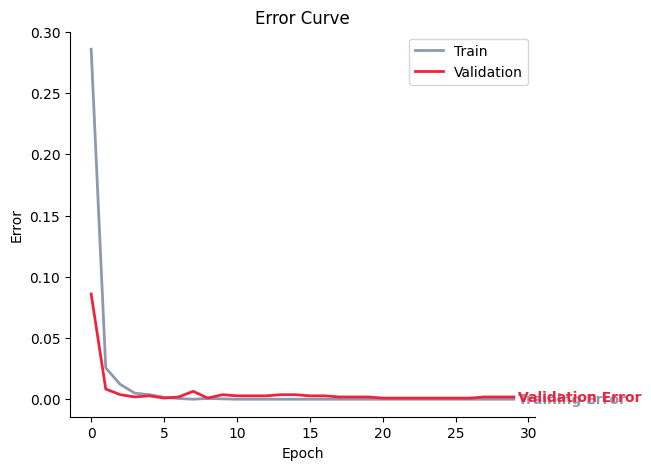

array([9.9999630e-01, 9.9999928e-01, 9.9997795e-01, ..., 5.8849914e-06,
       8.1682579e-08, 1.4465982e-08], dtype=float32)

In [ ]:
train(model_10, train_data, val_data, 64, 0.001, 30)

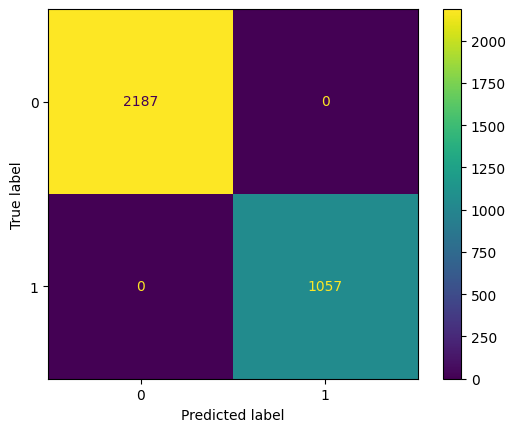

1.0

In [ ]:
get_acc(model_10, train_data, 64)

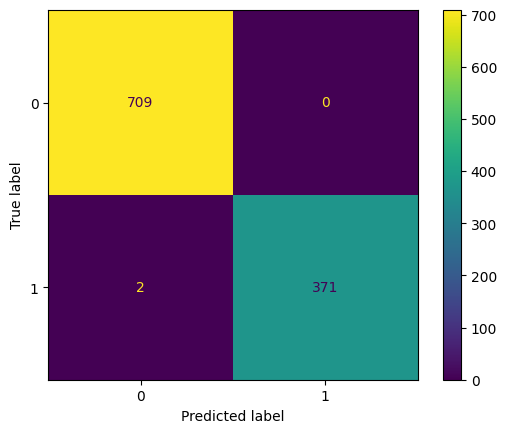

0.9981515711645101

In [ ]:
get_acc(model_10, val_data, 64)

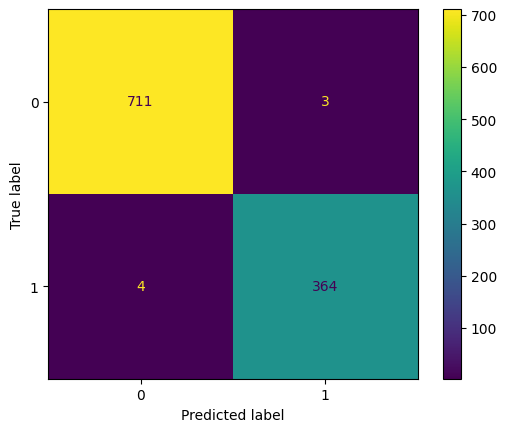

0.9935304990757856

In [ ]:
get_acc(model_10, test_data, 64)

## Testing out on Phone Collected Data by Nick

In [ ]:
class DataProcessing:
  def __init__(self, window_size = 400, window_overlap = 200):

    #Features we extract from the windows
    self.features = ['X_Acc_Mean', 'X_Acc_Max', 'X_Acc_Std', 'X_Acc_Min',
                     'X_Acc_IQR', 'X_Acc_Skew', 'X_Acc_Kurtosis', 'X_Acc_Energy', 'X_Acc_Jerk',
                     'Y_Acc_Mean', 'Y_Acc_Max', 'Y_Acc_Std', 'Y_Acc_Min',
                     'Y_Acc_IQR', 'Y_Acc_Skew', 'Y_Acc_Kurtosis', 'Y_Acc_Energy', 'Y_Acc_Jerk',
                     'Z_Acc_Mean', 'Z_Acc_Max', 'Z_Acc_Std', 'Z_Acc_Min',
                     'Z_Acc_IQR', 'Z_Acc_Skew', 'Z_Acc_Kurtosis', 'Z_Acc_Energy', 'Z_Acc_Jerk',
                     'XY_Acc_Cov', 'X_Gyro_Mean', 'X_Gyro_Max', 'X_Gyro_Std', 'X_Gyro_Min',
                     'X_Gyro_IQR', 'X_Gyro_Skew', 'X_Gyro_Kurtosis', 'X_Gyro_Energy', 'X_Gyro_Jerk',
                     'Y_Gyro_Mean', 'Y_Gyro_Max', 'Y_Gyro_Std', 'Y_Gyro_Min',
                     'Y_Gyro_IQR', 'Y_Gyro_Skew', 'Y_Gyro_Kurtosis', 'Y_Gyro_Energy', 'Y_Gyro_Jerk',
                     'Z_Acc_Mean', 'Z_Gyro_Max', 'Z_Gyro_Std', 'Z_Gyro_Min',
                     'Z_Gyro_IQR', 'Z_Gyro_Skew', 'Z_Gyro_Kurtosis', 'Z_Gyro_Energy', 'Z_Gyro_Jerk',
                     'XY_Gyro_Cov']

    self.window_size = window_size # window size is 2 seconds
    self.window_overlap = window_overlap # Overlap is 1 second

  #Feature Extraction Done by Anya and Nick
  def getcov(self, x_list_1, x_bar ,y_list, y_bar):
    """ Calculates the covariance of x and y in the selected window.

    Parameters:
    -----------
        x_list_1 : list
        x_bar :
          Average of x list
        y_list : list
        y_bar : float
          Average of y list

    Returns:
    --------
        covariace of x and y : float

    """
    cov = []
    for i in range(len(x_list_1)):
        cov.append((x_list_1[i] - x_bar) * (y_list[i] - y_bar))
    return sum(cov) / len(x_list_1) - 1

  def jerk(self, x_list, t_step):
    """ Calculated jerk, or the rate of change of the acceleration.

    Parameters:
    -----------
    x_list : list
    t_step : float

    Returns:
    --------
    jerk_list : list

    """
    jerk_list = []
    for i in range(len(x_list)-1):
        jerk_list.append((x_list[i+1] - x_list[i]) / t_step)

    jerk_list.append(jerk_list[-1])
    return sum(jerk_list) / len(jerk_list)

  def energy(self, x_list):
    """ Avergaged energy of the corresponding window

    Parameters:
    -----------
    x_list : list

    Returns:
    --------
    energy : float

    """
    sum = 0
    for i in range(len(x_list)):
        sum += x_list[i]**2
    return sum / len(x_list)



  def butter_lowpass_filter(self, data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

  def getmean(self,df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.mean()

  def getstd(self,df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.std()

  def getmin(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.min()

  def getmax(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.max()

  def getmedian(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.median()

  def getskewness(self, df, col):
    """if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.skew()

  def getkurtosis(self, df, col):
    """ if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.kurtosis()

  def getiqr(self, df, col):
    """ if col in (0,1,2,6,7,8):
      x = butter_lowpass_filter(df[col], 10, 100)
    else:"""
    x = df[col]
    return x.quantile(0.75) - x.quantile(0.25)
  #Window Sampling done by Krish
  def window_sample(self, file_df):
    """
    Description: Converts sensor readings of 15 seconds (200 Hz) into windows

    Inputs:   dir- path to the directory where the file is stored
              file- Name of the file with the sensor data

    Outputs:  DataFrame with the windows and features extracted
    """

    #Window size for activities is 2 seconds with a one second overlap
    window_x = 1
    new_df = []
    for i in range(0, len(file_df)-self.window_overlap, self.window_overlap):
      window = file_df.iloc[i:i+self.window_size:]
      sampled = []

      #Calling all functions for the specific window
      sampled.append(self.getmean(window, 'X_Acc_1'))
      sampled.append(self.getmax(window, 'X_Acc_1'))
      sampled.append(self.getstd(window, 'X_Acc_1'))
      sampled.append(self.getmin(window, 'X_Acc_1'))
      sampled.append(self.getiqr(window, 'X_Acc_1'))
      sampled.append(self.getskewness(window, 'X_Acc_1'))
      sampled.append(self.getkurtosis(window, 'X_Acc_1'))
      sampled.append(self.energy(window['X_Acc_1'].tolist()))
      sampled.append(self.jerk(window['X_Acc_1'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Y_Acc_1'))
      sampled.append(self.getmax(window, 'Y_Acc_1'))
      sampled.append(self.getstd(window, 'Y_Acc_1'))
      sampled.append(self.getmin(window, 'Y_Acc_1'))
      sampled.append(self.getiqr(window, 'Y_Acc_1'))
      sampled.append(self.getskewness(window, 'Y_Acc_1'))
      sampled.append(self.getkurtosis(window, 'Y_Acc_1'))
      sampled.append(self.energy(window['Y_Acc_1'].tolist()))
      sampled.append(self.jerk(window['Y_Acc_1'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Z_Acc_1'))
      sampled.append(self.getmax(window, 'Z_Acc_1'))
      sampled.append(self.getstd(window, 'Z_Acc_1'))
      sampled.append(self.getmin(window, 'Z_Acc_1'))
      sampled.append(self.getiqr(window, 'Z_Acc_1'))
      sampled.append(self.getskewness(window, 'Z_Acc_1'))
      sampled.append(self.getkurtosis(window, 'Z_Acc_1'))
      sampled.append(self.energy(window['Z_Acc_1'].tolist()))
      sampled.append(self.jerk(window['Z_Acc_1'].tolist(), (2/self.window_size)))
      sampled.append(self.getcov(window['X_Acc_1'].tolist(), self.getmean(window, 'X_Acc_1'), window['Y_Acc_1'].tolist(), self.getmean(window, 'Y_Acc_1')))


      sampled.append(self.getmean(window, 'X_Gyro'))
      sampled.append(self.getmax(window, 'X_Gyro'))
      sampled.append(self.getstd(window, 'X_Gyro'))
      sampled.append(self.getmin(window, 'X_Gyro'))
      sampled.append(self.getiqr(window, 'X_Gyro'))
      sampled.append(self.getskewness(window, 'X_Gyro'))
      sampled.append(self.getkurtosis(window, 'X_Gyro'))
      sampled.append(self.energy(window['X_Gyro'].tolist()))
      sampled.append(self.jerk(window['X_Gyro'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Y_Gyro'))
      sampled.append(self.getmax(window, 'Y_Gyro'))
      sampled.append(self.getstd(window, 'Y_Gyro'))
      sampled.append(self.getmin(window, 'Y_Gyro'))
      sampled.append(self.getiqr(window, 'Y_Gyro'))
      sampled.append(self.getskewness(window, 'Y_Gyro'))
      sampled.append(self.getkurtosis(window, 'Y_Gyro'))
      sampled.append(self.energy(window['Y_Gyro'].tolist()))
      sampled.append(self.jerk(window['Y_Gyro'].tolist(), (2/self.window_size)))

      sampled.append(self.getmean(window, 'Z_Gyro'))
      sampled.append(self.getmax(window, 'Z_Gyro'))
      sampled.append(self.getstd(window, 'Z_Gyro'))
      sampled.append(self.getmin(window, 'Z_Gyro'))
      sampled.append(self.getiqr(window, 'Z_Gyro'))
      sampled.append(self.getskewness(window, 'Z_Gyro'))
      sampled.append(self.getkurtosis(window, 'Z_Gyro'))
      sampled.append(self.energy(window['Z_Gyro'].tolist()))
      sampled.append(self.jerk(window['Z_Gyro'].tolist(), (2/self.window_size)))
      sampled.append(self.getcov(window['X_Gyro'].tolist(), self.getmean(window, 'X_Gyro'), window['Y_Gyro'].tolist(), self.getmean(window, 'Y_Gyro')))

      new_df.append(sampled)
      window_x += 1

    #Returns the created DataFrame
    return pd.DataFrame(new_df, columns=self.features)

In [ ]:
phone_data = []
phone_labels = []
sampler = DataProcessing(20, 10)
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data'):
  for file in files:
    if file[0] == 'p':
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      file_df = file_df[20:170]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      phone_labels.append(1)
    else:
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      if len(file_df)<150:
        cols = file_df.columns
        file_np = np.array(file_df)
        file_df = pd.DataFrame(np.array(np.vstack((file_np, np.tile(file_np[-1], (150-len(file_df), 1))))), columns=cols)
      elif len(file_df)>150:
        file_df = file_df[:150]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      phone_labels.append(0)

In [ ]:
phone_data = np.array(phone_data)

In [ ]:
phone_labels = np.array(phone_labels)
phone_labels.shape

(97,)

In [ ]:
phone_data.shape

(97, 14, 56)

In [ ]:
phonecombined = (listOfTuples((torch.from_numpy(phone_data)).to(torch.float), torch.from_numpy(phone_labels).to(torch.float)))
random.shuffle(phonecombined)

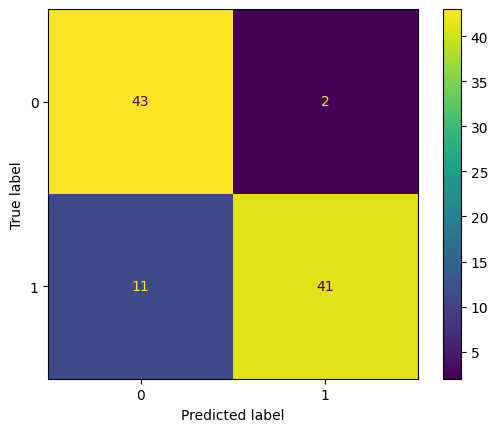

0.865979381443299

In [ ]:
get_acc(model_1, phonecombined, 64)

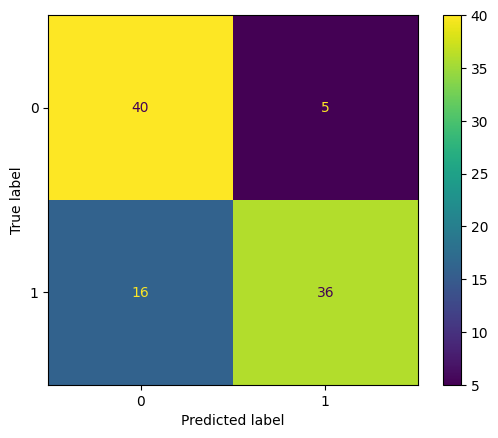

0.7835051546391752

In [ ]:
get_acc(model_2, phonecombined, 32)

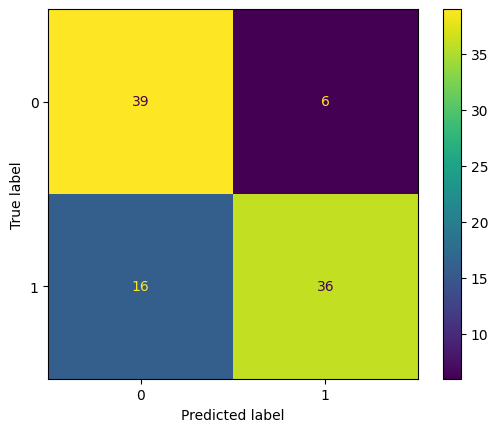

0.7731958762886598

In [ ]:
get_acc(model_3, phonecombined, 128)

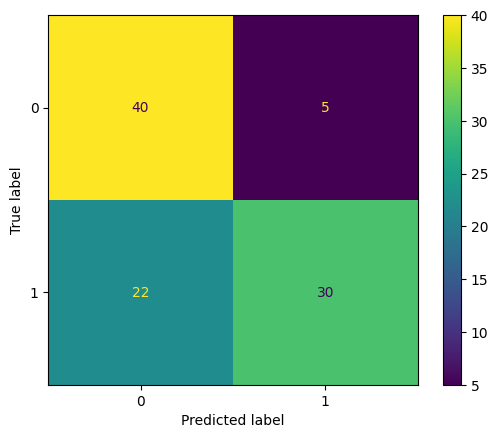

0.7216494845360825

In [ ]:
get_acc(model_4, phonecombined, 64)

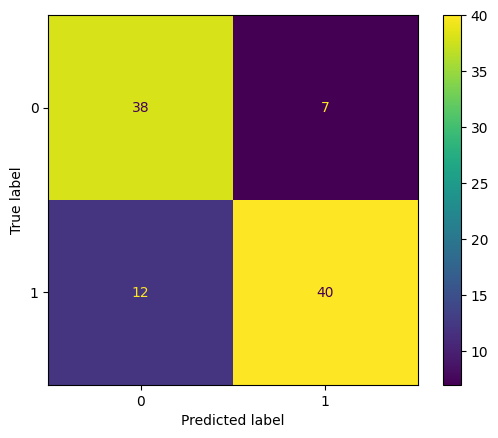

0.8041237113402062

In [ ]:
get_acc(model_6, phonecombined, 64)

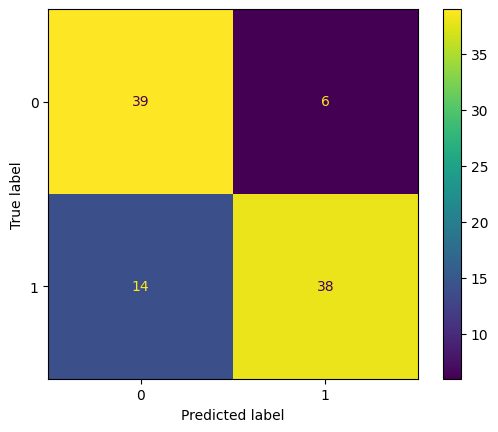

0.7938144329896908

In [ ]:
get_acc(model_7, phonecombined, 64)

**Testing out Version 5 (due to Mutli Class Classification, preprocessing for Phone Collected Data is slightly different)**

In [ ]:
phone_data = []
phone_labels = []
sampler = DataProcessing(20, 10)
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data'):
  for file in files:
    if file[0] == 'p':
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      file_df = file_df[20:170]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      phone_labels.append(0) #Fall is marked as 0
    else:
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      if len(file_df)<150:
        cols = file_df.columns
        file_np = np.array(file_df)
        file_df = pd.DataFrame(np.array(np.vstack((file_np, np.tile(file_np[-1], (150-len(file_df), 1))))), columns=cols)
      elif len(file_df)>150:
        file_df = file_df[:150]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      if file[:3] == 'D01' or file[:3] == 'D02':
        phone_labels.append(1) #Walking
      elif file[:3] == 'D03' or file[:3] == 'D04':
        phone_labels.append(2) #Jogging
      elif file[:3] == 'D05' or file[:3] == 'D06':
        phone_labels.append(3) #Stair movement
      elif file[:3] == 'D07' or file[:3] == 'D08' or file[:3] == 'D09' or file[:3] == 'D10':
        phone_labels.append(4) #Sitting
      elif file[:3] == 'D11' or file[:3] == 'D18':
        phone_labels.append(5) #Collapse into chair or stumbling
      elif file[:3] == 'D12' or file[:3] == 'D13':
        phone_labels.append(6) #Lying
      elif file[:3] == 'D14':
        phone_labels.append(7) #Changing Lying Posture
      elif file[:3] == 'D15' or file[:3] == 'D16':
        phone_labels.append(8) #Bending
      elif file[:3] == 'D17':
        phone_labels.append(9) #Car in/out
      elif file[:3] == 'D19':
        phone_labels.append(10) #Gentle Jump

In [ ]:
phone_data = np.array(phone_data)

In [ ]:
phone_labels = np.array(phone_labels)
phone_labels.shape

(97,)

In [ ]:
phone_data.shape

(97, 14, 56)

In [ ]:
phonecombined = (listOfTuples((torch.from_numpy(phone_data)).to(torch.float), torch.from_numpy(phone_labels).to(torch.float)))
random.shuffle(phonecombined)

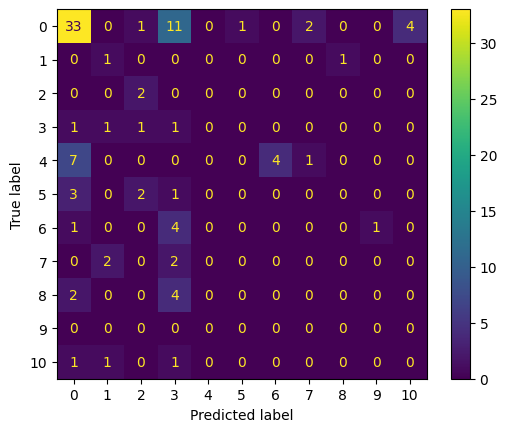

0.38144329896907214

In [ ]:
get_acc_multi(model_5, phonecombined, 64)

**Testing out Version 8**

In [ ]:
phone_data = []
phone_labels = []
sampler = DataProcessing(20, 10)
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data'):
  for file in files:
    if file[0] == 'p':
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      file_df = file_df[20:170]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      phone_labels.append(1)
    else:
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      if len(file_df)<150:
        cols = file_df.columns
        file_np = np.array(file_df)
        file_df = pd.DataFrame(np.array(np.vstack((file_np, np.tile(file_np[-1], (150-len(file_df), 1))))), columns=cols)
      elif len(file_df)>150:
        file_df = file_df[:150]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(file_sampled)
      phone_labels.append(0)

In [ ]:
phone_data = np.array(phone_data)
phone_labels = np.array(phone_labels)

In [ ]:
scaler_phone = MinMaxScaler()
scaler_phone.fit(np.row_stack(phone_data))

MinMaxScaler()

In [ ]:
phone_data.shape

(97, 14, 56)

In [ ]:
phone_labels.shape

(97,)

In [ ]:
phone_data_scaled = np.array([scaler_phone.transform(phone_data[i]) for i in range(len(phone_data))])

In [ ]:
phonecombined = (listOfTuples((torch.from_numpy(phone_data_scaled)).to(torch.float), torch.from_numpy(phone_labels).to(torch.float)))
random.shuffle(phonecombined)

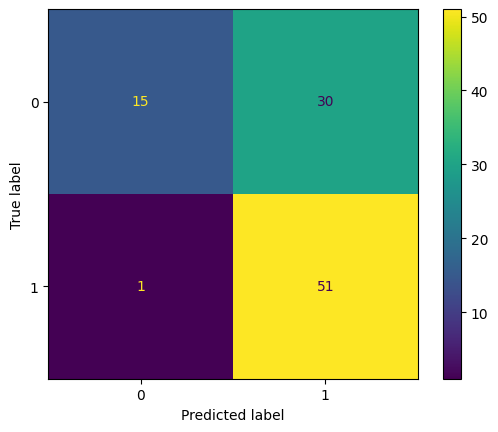

0.6804123711340206

In [ ]:
get_acc(model_8, phonecombined, 64)

**Testing out Model 9**


In [ ]:
phone_data_acc = np.array([phone_data[i][:,:28] for i in range(len(phone_data))])

In [ ]:
phonecombined = (listOfTuples((torch.from_numpy(phone_data_acc)).to(torch.float), torch.from_numpy(phone_labels).to(torch.float)))
random.shuffle(phonecombined)

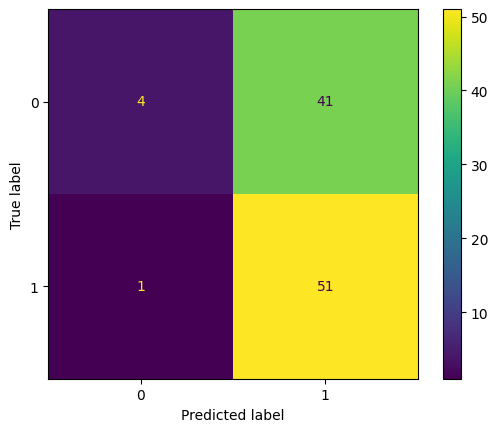

0.5670103092783505

In [ ]:
get_acc(model_9, phonecombined, 64)

**Testing out Version 10**

In [ ]:
phone_data = []
phone_labels = []
scaler_phone = MinMaxScaler()
sampler = DataProcessing(20, 10)
for dir, _, files in os.walk('/content/gdrive/MyDrive/Phone Collected Data'):
  for file in files:
    if file[0] == 'p':
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      file_df = file_df[20:170]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(scaler.fit_transform(file_sampled))
      phone_labels.append(1)
    else:
      file_df = pd.read_csv(os.path.join(dir, file))
      cols = file_df.columns
      file_df['Timestamp'] = file_df['seconds_elapsed']
      file_df['X_Acc_1'] = file_df['accelerometer_x']*-1
      file_df['Y_Acc_1'] = file_df['accelerometer_y']*-1
      file_df['Z_Acc_1'] = file_df['accelerometer_z']*-1
      file_df['X_Gyro'] = file_df['gyroscope_x']*(-180/3.14)
      file_df['Y_Gyro'] = file_df['gyroscope_y']*(-180/3.14)
      file_df['Z_Gyro'] = file_df['gyroscope_z']*(-180/3.14)
      file_df = file_df.drop(cols, axis=1)
      if len(file_df)<150:
        cols = file_df.columns
        file_np = np.array(file_df)
        file_df = pd.DataFrame(np.array(np.vstack((file_np, np.tile(file_np[-1], (150-len(file_df), 1))))), columns=cols)
      elif len(file_df)>150:
        file_df = file_df[:150]
      file_sampled = sampler.window_sample(file_df)
      phone_data.append(scaler.fit_transform(file_sampled))
      phone_labels.append(0)

In [ ]:
phone_data = np.array(phone_data)
phone_labels = np.array(phone_labels)

In [ ]:
phonecombined = (listOfTuples((torch.from_numpy(phone_data)).to(torch.float), torch.from_numpy(phone_labels).to(torch.float)))
random.shuffle(phonecombined)

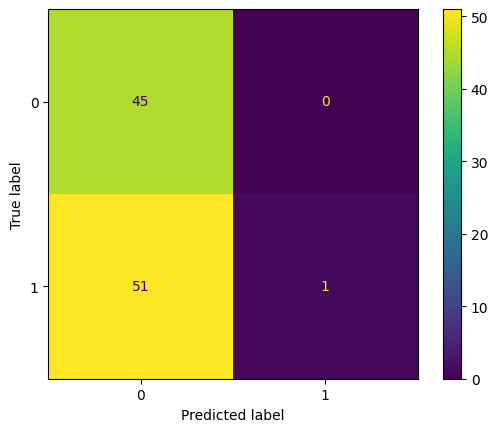

0.4742268041237113

In [ ]:
get_acc(model_10, phonecombined, 64)

## Saving Models

In [ ]:
torch.save(model_1, '/content/gdrive/MyDrive/model_1.pth')

In [ ]:
torch.save(model_2, '/content/gdrive/MyDrive/model_2.pth')

In [ ]:
torch.save(model_3, '/content/gdrive/MyDrive/model_3.pth')

In [ ]:
torch.save(model_4, '/content/gdrive/MyDrive/model_4.pth')

In [ ]:
torch.save(model_6, '/content/gdrive/MyDrive/model_6.pth')

In [ ]:
torch.save(model_7, '/content/gdrive/MyDrive/model_7.pth')

In [ ]:
torch.save(model_5, '/content/gdrive/MyDrive/model_5.pth')

In [ ]:
torch.save(model_8, '/content/gdrive/MyDrive/model_8.pth')

In [ ]:
torch.save(model_9, '/content/gdrive/MyDrive/model_9.pth')

In [ ]:
torch.save(model_10, '/content/gdrive/MyDrive/model_10.pth')

While Model 1 achieves the best set of results on the team's Phone Collected Data, given its sensitivity to batch sizes and the order of inputs as proven above, Model 6 given its reasonable accuracy on both SisFall and Phone Collected Data and it's insensitivity to size and distribution of input data in batches, is the proposed model for our team.

**Note: Training Version 3 contains additional models that take in raw sensor data as input however due to their poor **